<a href="https://colab.research.google.com/github/varun-beep/DeepLearning/blob/main/Image_Captioning_using_RNN(7).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, GRU, Dense
from nltk.translate.bleu_score import sentence_bleu

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
class_names = ["airplane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [3]:
train_images, test_images = train_images / 255.0, test_images / 255.0

In [4]:
train_captions = [f"A {class_names[label[0]]}" for label in train_labels]
test_captions = [f"A {class_names[label[0]]}" for label in test_labels]

In [5]:
tokenizer = Tokenizer(num_words=1000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_captions)
sequences = tokenizer.texts_to_sequences(train_captions)
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [6]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
base_model.trainable = False
encoder = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D()
])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1

decoder = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    GRU(units, return_sequences=True),
    Dense(vocab_size, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [8]:
decoder.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

In [9]:
decoder.fit(padded_sequences, np.expand_dims(padded_sequences, -1), epochs=10, batch_size=64)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 48s 57ms/step - loss: 0.2108
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - loss: 3.0994e-05
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - loss: 1.0390e-05
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - loss: 4.9031e-06
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - loss: 2.6814e-06
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 41ms/step - loss: 1.5580e-06
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - loss: 9.5042e-07
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - loss: 5.6319e-07
Epoch 9/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 42ms/step - loss: 3.7169e-07
Epoch 10/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - loss: 2.2941e-07


In [46]:
def generate_caption(image):
    features = encoder.predict(np.expand_dims(image, axis=0))
    sequence = [tokenizer.word_index['a']]
    for _ in range(max_length - 1):
        padded_seq = pad_sequences([sequence], maxlen=max_length, padding='post')
        predicted_id = np.argmax(decoder.predict(padded_seq), axis=-1)[0][-1]
        if predicted_id == 0:
            break
        sequence.append(predicted_id)
    return ' '.join(tokenizer.index_word[i] for i in sequence if i in tokenizer.index_word)

In [47]:
sample_idx = np.random.randint(0, len(test_images))
pred_caption = generate_caption(test_images[sample_idx])
print(f"Actual: {test_captions[sample_idx]}")
print(f"Predicted: {pred_caption}")
print(f"BLEU Score: {sentence_bleu([test_captions[sample_idx].split()], pred_caption.split())}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Actual: A airplane
Predicted: a airplane
BLEU Score: 1.5319719891192393e-231


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

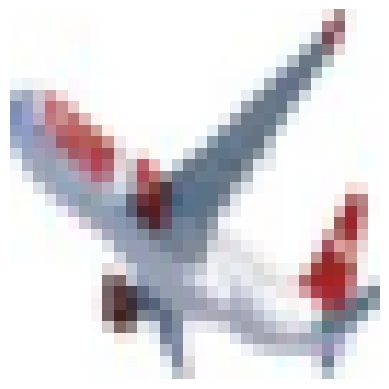

In [48]:
plt.imshow(test_images[sample_idx])
plt.axis('off')
plt.show()